In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d andrewmvd/animal-faces

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 98% 682M/696M [00:09<00:00, 94.9MB/s]
100% 696M/696M [00:09<00:00, 79.9MB/s]


In [4]:
!unzip -q animal-faces.zip -d animal_faces


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [6]:
base_dir = 'animal_faces/afhq'

# Define the paths for training and validation directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')



In [7]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],

)

val_datagen = ImageDataGenerator(rescale=1./255)



In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 14630 images belonging to 3 classes.


In [13]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1500 images belonging to 3 classes.


In [14]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 254, 254, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 128)     512       
 chNormalization)                                                
                                                        

In [20]:
from tensorflow.keras import optimizers

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),  # Adjusted learning rate
    metrics=['accuracy']
)

EPOCHS = 10

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
457/457 [==============================] - 300s 654ms/step - loss: 0.0814 - accuracy: 0.9708 - val_loss: 0.0358 - val_accuracy: 0.9885
Epoch 2/10
457/457 [==============================] - 303s 663ms/step - loss: 0.0838 - accuracy: 0.9692 - val_loss: 0.0418 - val_accuracy: 0.9864
Epoch 3/10
457/457 [==============================] - 308s 674ms/step - loss: 0.0783 - accuracy: 0.9714 - val_loss: 0.0323 - val_accuracy: 0.9898
Epoch 4/10
457/457 [==============================] - 302s 661ms/step - loss: 0.0747 - accuracy: 0.9723 - val_loss: 0.0383 - val_accuracy: 0.9891
Epoch 5/10
457/457 [==============================] - 301s 658ms/step - loss: 0.0751 - accuracy: 0.9713 - val_loss: 0.0348 - val_accuracy: 0.9912
Epoch 6/10
457/457 [==============================] - 302s 660ms/step - loss: 0.0703 - accuracy: 0.9749 - val_loss: 0.0339 - val_accuracy: 0.9905
Epoch 7/10
457/457 [==============================] - 301s 658ms/step - loss: 0.0720 - accuracy: 0.9724 - val_loss: 0.0340 -

In [22]:
eval_result = model.evaluate(val_generator)
print(f"Validation Loss: {eval_result[0]}")
print(f"Validation Accuracy: {eval_result[1]}")

47/47 [==============================] - 16s 344ms/step - loss: 0.0319 - accuracy: 0.9900
Validation Loss: 0.03192708641290665
Validation Accuracy: 0.9900000095367432


1/1 [==============================] - 0s 20ms/step
The image is predicted to be a: cat


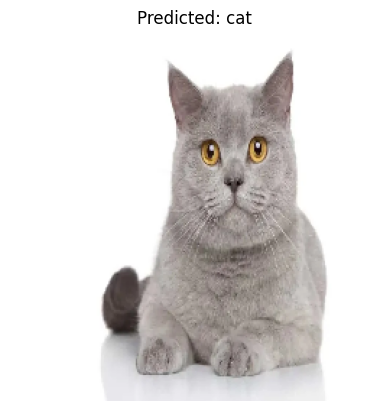

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img, img_array

new_image_path = '/content/cattest.webp'


loaded_img, img_array = load_and_preprocess_image(new_image_path)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])


class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(f"The image is predicted to be a: {predicted_label}")


plt.imshow(loaded_img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 18ms/step
The image is predicted to be a: dog


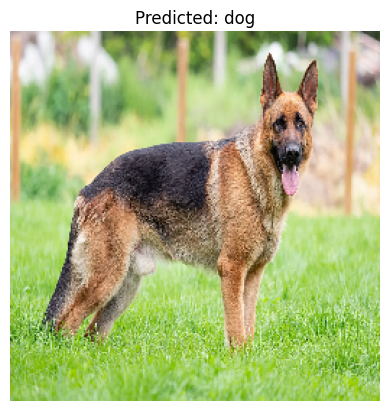

In [26]:
new_image_path = '/content/German-Shepherd-dog-Alsatian.webp'


loaded_img, img_array = load_and_preprocess_image(new_image_path)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])


class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(f"The image is predicted to be a: {predicted_label}")


plt.imshow(loaded_img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 22ms/step
The image is predicted to be a: dog


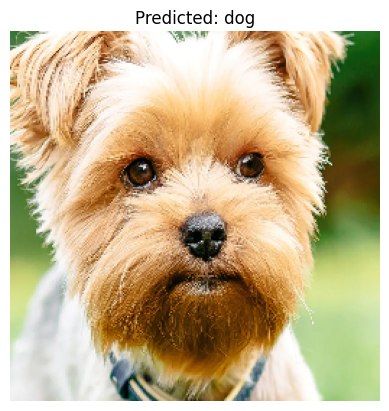

In [28]:
new_image_path = '/content/small-dog-owners-1.jpg'


loaded_img, img_array = load_and_preprocess_image(new_image_path)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])


class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(f"The image is predicted to be a: {predicted_label}")


plt.imshow(loaded_img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 20ms/step
The image is predicted to be a: wild


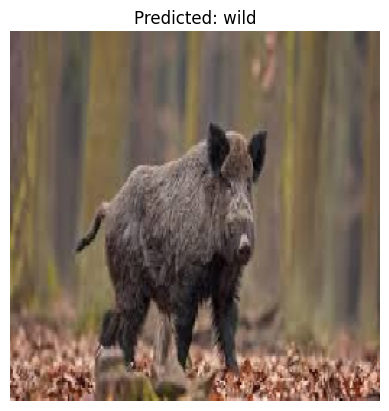

In [29]:
new_image_path = '/content/pork.jpg'


loaded_img, img_array = load_and_preprocess_image(new_image_path)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])


class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(f"The image is predicted to be a: {predicted_label}")


plt.imshow(loaded_img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 88ms/step
The image is predicted to be a: wild


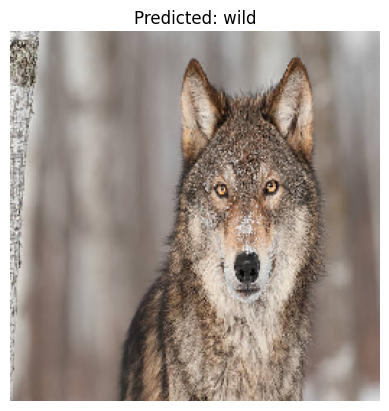

In [30]:
new_image_path = '/content/wolfjpg.jpg'


loaded_img, img_array = load_and_preprocess_image(new_image_path)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])


class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(f"The image is predicted to be a: {predicted_label}")


plt.imshow(loaded_img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()